Студент: Баширов Роман

Группа: J4241

Лабораторная 2. Портфель Марковица.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.optimize import minimize

np.set_printoptions(suppress=True)

In [43]:
df = pd.read_csv('../data/tikers.txt', decimal='.', delimiter=';')

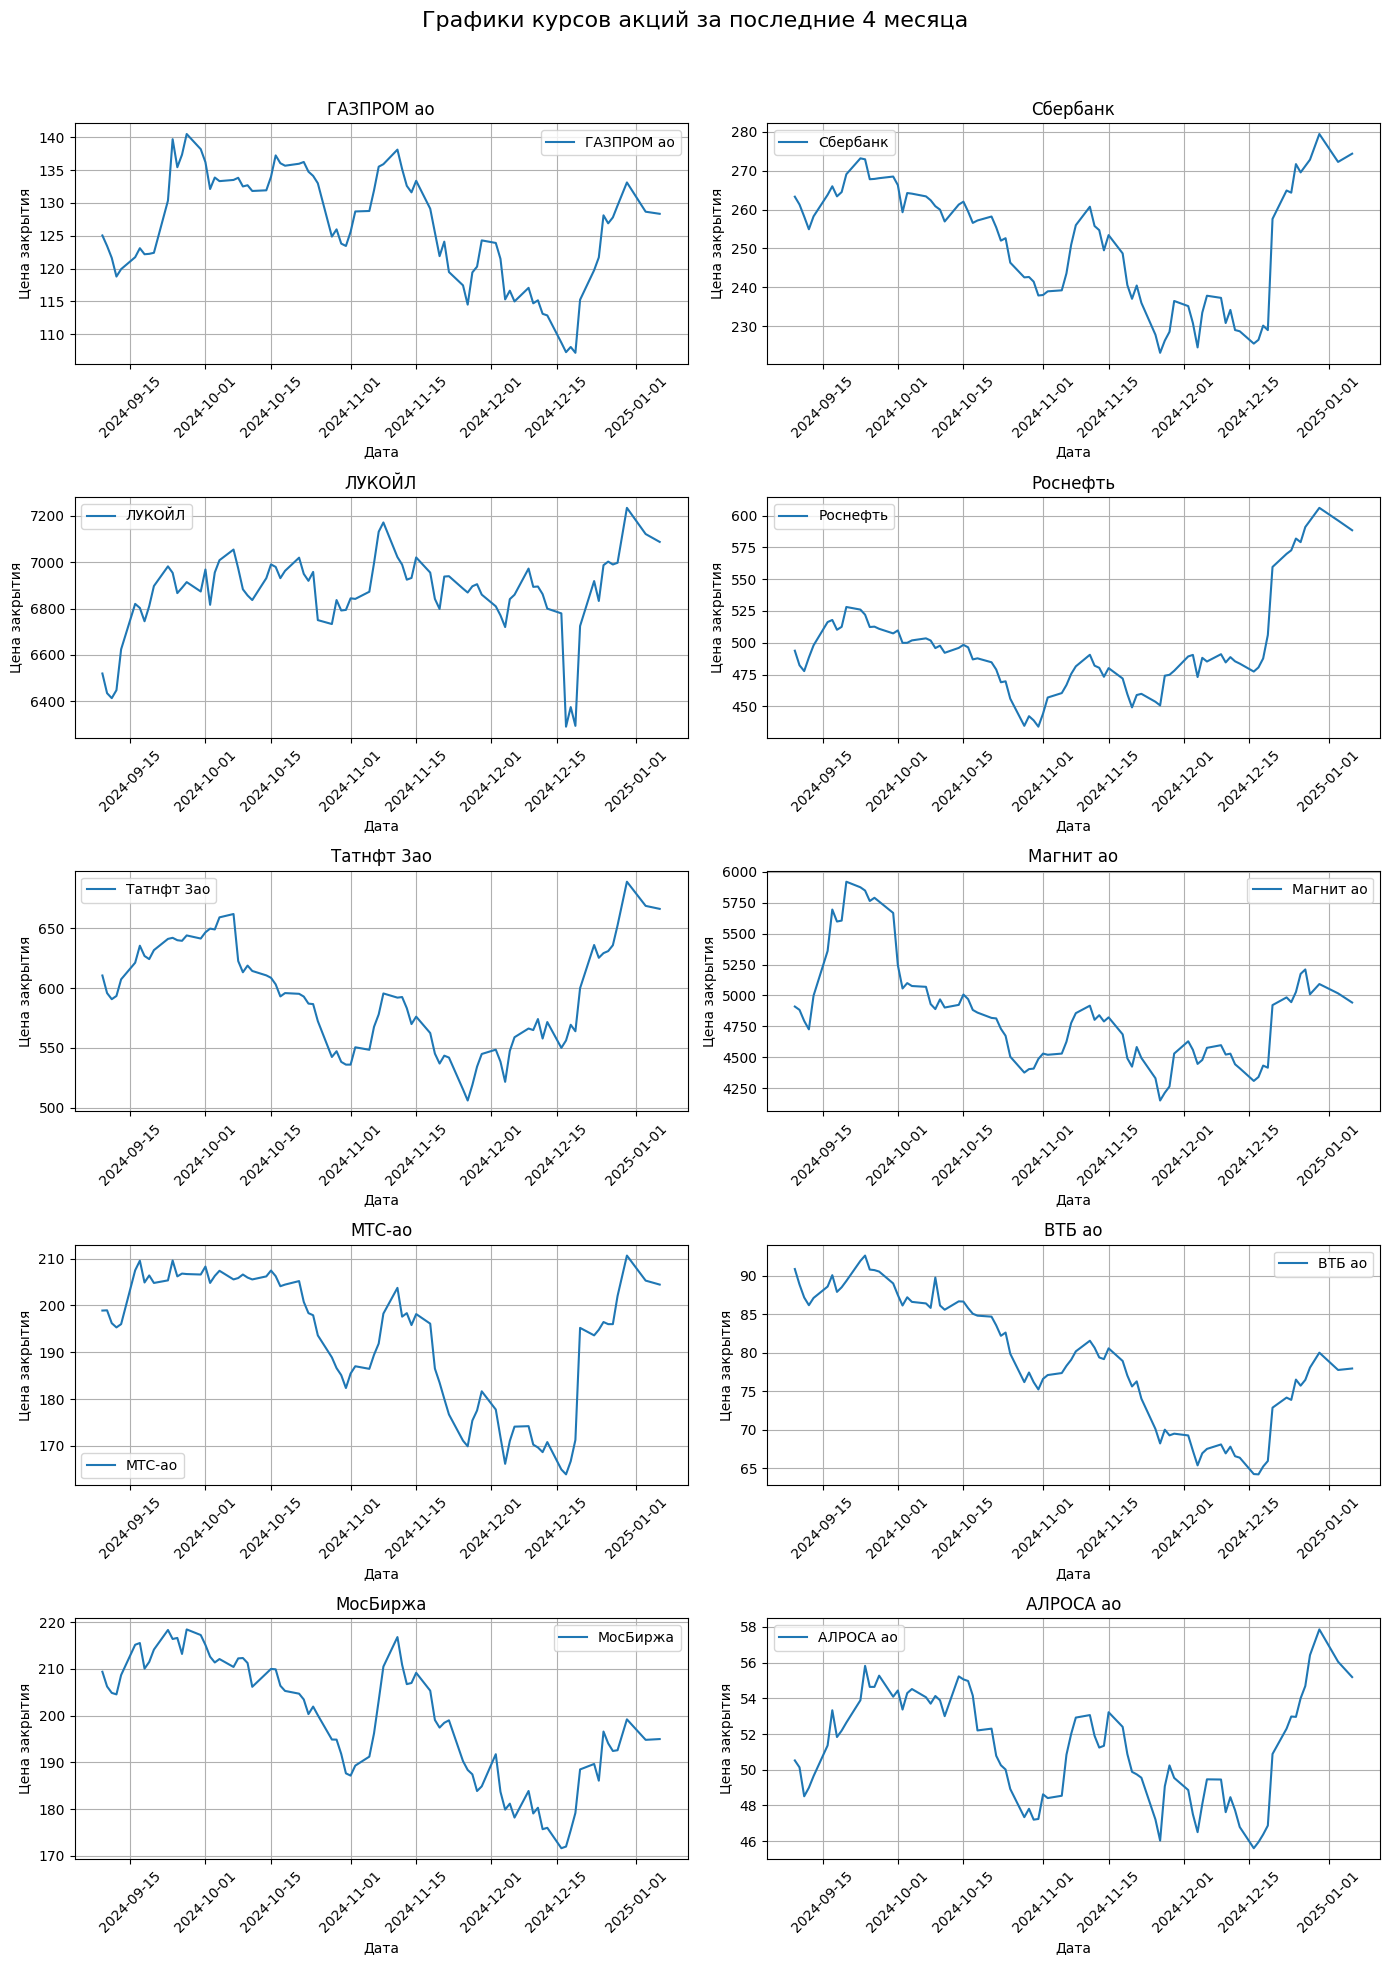

['ГАЗПРОМ ао' 'Сбербанк' 'ЛУКОЙЛ' 'Роснефть' 'Татнфт 3ао' 'Магнит ао'
 'МТС-ао' 'ВТБ ао' 'МосБиржа' 'АЛРОСА ао']


In [44]:
# Фильтрация данных за последние 4 месяца
df['<DATETIME>'] = pd.to_datetime(df['<DATE>'], format='%Y%m%d')
filtered_df = df[df['<DATETIME>'] >= pd.Timestamp.now() - pd.DateOffset(months=4)]

# Уникальные тикеры
tickers = df['<TICKER>'].unique()[:10]  # Выбираем первые 10 тикеров

# Создание сетки 5x2 для графиков
fig, axes = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle('Графики курсов акций за последние 4 месяца', fontsize=16)

# Построение графиков для каждого тикера
for i, ticker in enumerate(tickers):
    row = i // 2
    col = i % 2
    ticker_data = filtered_df[filtered_df['<TICKER>'] == ticker]
    axes[row, col].plot(ticker_data['<DATETIME>'], ticker_data['<CLOSE>'], label=ticker)
    axes[row, col].set_title(ticker)
    axes[row, col].set_xlabel('Дата')
    axes[row, col].set_ylabel('Цена закрытия')
    axes[row, col].grid()
    axes[row, col].legend()
    
    # Поворот подписей по оси X на 45 градусов
    for tick in axes[row, col].get_xticklabels():
        tick.set_rotation(45)


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Регулировка расположения графиков
plt.show()

print(tickers)

Note: Газпром, Магнит, ВТБ и МосБиржа имеют явно "отрицательный рост". Посмотрим, что покажет минимизация для разных типов портфелей.

In [45]:
prices = filtered_df.pivot(index='<DATETIME>', columns='<TICKER>', values='<CLOSE>')
# # Расчет дневных доходностей
returns = prices.pct_change().dropna()
returns

<TICKER>,АЛРОСА ао,ВТБ ао,ГАЗПРОМ ао,ЛУКОЙЛ,МТС-ао,Магнит ао,МосБиржа,Роснефть,Сбербанк,Татнфт 3ао
<DATETIME>,,,,,,,,,,
2024-09-10,-0.007720,-0.022112,-0.012796,-0.013037,0.000251,-0.005499,-0.015043,-0.023188,-0.007672,-0.024079
2024-09-11,-0.032316,-0.019012,-0.014744,-0.003341,-0.013823,-0.018329,-0.006642,-0.009537,-0.011826,-0.008560
2024-09-12,0.009895,-0.011468,-0.023351,0.005379,-0.004587,-0.014186,-0.001562,0.022397,-0.012665,0.004571
2024-09-13,0.013268,0.010905,0.009513,0.027373,0.003584,0.057666,0.020239,0.019552,0.013023,0.023424
2024-09-16,0.034649,0.016984,0.015178,0.029587,0.058673,0.072329,0.031049,0.036747,0.021452,0.022888
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.012778,0.009902,0.007093,-0.001785,0.000000,0.006958,-0.008399,0.020549,0.006084,0.007767
2024-12-28,0.031633,0.020918,0.014164,0.001073,0.030612,-0.038580,0.000831,0.008460,0.006010,0.026109
2024-12-30,0.025523,0.024843,0.027160,0.033867,0.042822,0.016570,0.034318,0.016862,0.024191,0.055947


In [46]:
# Функция для расчета доходности и риска портфеля
def portfolio_stats(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_volatility

# Функция для минимизации риска
def minimize_risk(weights, returns):
    return portfolio_stats(weights, returns)[1]

# Функция для максимизации коэффициента Шарпа
def maximize_sharpe(weights, returns, risk_free_rate=0):
    ret, vol = portfolio_stats(weights, returns)
    return -(ret - risk_free_rate) / vol

# Ограничения и начальные условия
num_assets = len(tickers)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

In [47]:

# Оптимизация для минимизации риска
optimal_risk = minimize(minimize_risk, initial_guess, args=(returns,),
                        method='SLSQP', bounds=bounds, constraints=constraints)

# Оптимизация для максимизации коэффициента Шарпа
optimal_sharpe = minimize(maximize_sharpe, initial_guess, args=(returns,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# Создание таблицы для минимизации риска
risk_table = pd.DataFrame({
    'Акция': tickers,
    'Доля': np.round(optimal_risk.x, 8)
})

# Создание таблицы для максимизации коэффициента Шарпа
sharpe_table = pd.DataFrame({
    'Акция': tickers,
    'Доля': np.round(optimal_sharpe.x, 8)
})

# Вывод таблиц с помощью tabulate
print("Оптимальные доли для минимизации риска:")
print(tabulate(risk_table, headers='keys', tablefmt='pretty', showindex=False))

print("\nОптимальные доли для максимизации коэффициента Шарпа:")
print(tabulate(sharpe_table, headers='keys', tablefmt='pretty', showindex=False))

Оптимальные доли для минимизации риска:
+------------+------------+
|   Акция    |    Доля    |
+------------+------------+
| ГАЗПРОМ ао |    0.0     |
|  Сбербанк  |    0.0     |
|   ЛУКОЙЛ   |    0.0     |
|  Роснефть  | 0.64944186 |
| Татнфт 3ао |    0.0     |
| Магнит ао  |    0.0     |
|   МТС-ао   | 0.27775879 |
|   ВТБ ао   | 0.06012261 |
|  МосБиржа  |    0.0     |
| АЛРОСА ао  | 0.01267675 |
+------------+------------+

Оптимальные доли для максимизации коэффициента Шарпа:
+------------+------------+
|   Акция    |    Доля    |
+------------+------------+
| ГАЗПРОМ ао |    0.0     |
|  Сбербанк  |    0.0     |
|   ЛУКОЙЛ   |    0.0     |
|  Роснефть  | 0.06112356 |
| Татнфт 3ао |    0.0     |
| Магнит ао  |    0.0     |
|   МТС-ао   |    0.0     |
|   ВТБ ао   | 0.93887644 |
|  МосБиржа  |    0.0     |
| АЛРОСА ао  |    0.0     |
+------------+------------+


In [48]:
# Средний портфель
equal_weights = np.array([1 / num_assets] * num_assets)
equal_ret, equal_vol = portfolio_stats(equal_weights, returns)

# Портфель с минимальным риском
min_risk_ret, min_risk_vol = portfolio_stats(optimal_risk.x, returns)

# Портфель с максимальным коэффициентом Шарпа
max_sharpe_ret, max_sharpe_vol = portfolio_stats(optimal_sharpe.x, returns)

# Создаем таблицу
table = [
    ["Средний портфель", equal_ret, equal_vol, equal_weights],
    ["Минимальный риск", min_risk_ret, min_risk_vol, (optimal_risk.x)],
    ["Максимальный коэффициент Шарпа", max_sharpe_ret, max_sharpe_vol, (optimal_sharpe.x)]
]

# Форматируем вывод
headers = ["Тип портфеля", "Доходность", "Риск", "Доли"]
print(tabulate(table, headers=headers, floatfmt=".4f"))

Тип портфеля                      Доходность    Риск  Доли
------------------------------  ------------  ------  ----------------------------------------------------------
Средний портфель                      0.1577  0.2979  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Минимальный риск                      0.1798  0.2444  [0.         0.         0.         0.64944186 0.         0.
                                                       0.27775879 0.06012261 0.         0.01267675]
Максимальный коэффициент Шарпа        0.5678  0.3207  [0.         0.         0.         0.06112356 0.         0.
                                                       0.         0.93887644 0.         0.        ]


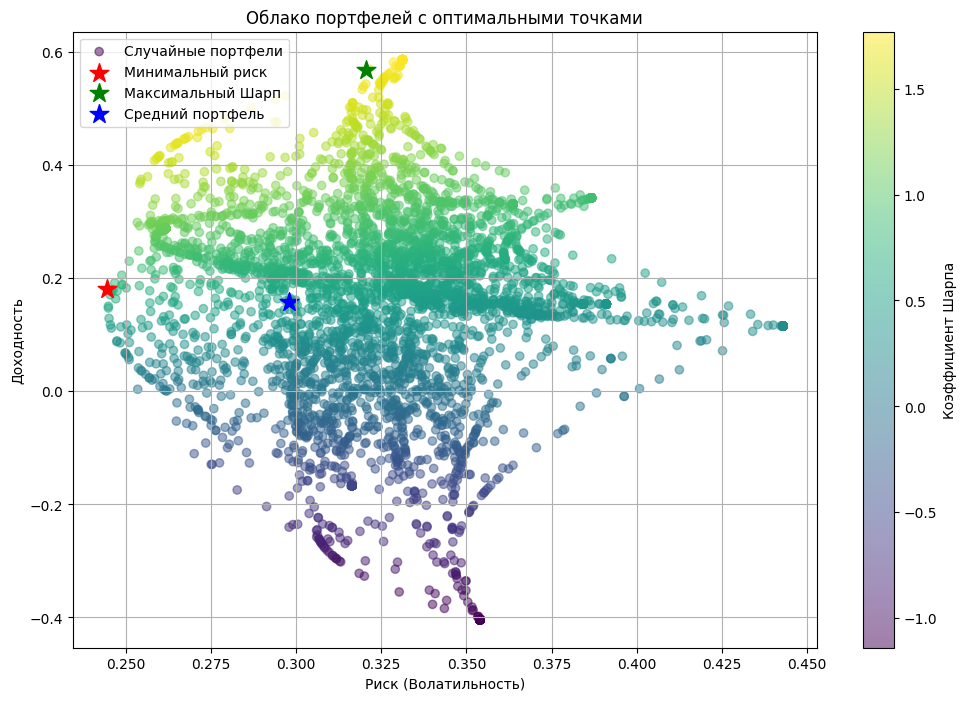

In [49]:
# Генерация случайных портфелей
num_portfolios = 5000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    # Случайное количество акций (N), в которые будут вложены средства
    N = np.random.randint(1, num_assets + 1 - 6)  # N от 1 до num_assets
    selected_assets = np.random.choice(num_assets, N, replace=False)  # Случайный выбор N акций
    
    # Генерация весов только для выбранных акций
    weights = np.zeros(num_assets)
    selected_weights = np.random.random(N)
    selected_weights /= np.sum(selected_weights)  # Нормализация весов
    weights[selected_assets] = selected_weights
    
    # Расчет доходности и риска портфеля
    ret, vol = portfolio_stats(weights, returns)
    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = (ret - 0) / vol  # Коэффициент Шарпа (без учета безрисковой ставки)


# Построение графика облака портфелей
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.5, label='Случайные портфели')
plt.colorbar(label='Коэффициент Шарпа')

# Добавление точек для оптимальных портфелей
## Портфель с минимальным риском
min_risk_ret, min_risk_vol = portfolio_stats(optimal_risk.x, returns)
plt.scatter(min_risk_vol, min_risk_ret, color='red', marker='*', s=200, label='Минимальный риск')

## Портфель с максимальным коэффициентом Шарпа
max_sharpe_ret, max_sharpe_vol = portfolio_stats(optimal_sharpe.x, returns)
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='green', marker='*', s=200, label='Максимальный Шарп')

## Средний портфель (равные доли)
equal_ret, equal_vol = portfolio_stats(equal_weights, returns)
plt.scatter(equal_vol, equal_ret, color='blue', marker='*', s=200, label='Средний портфель')

# Настройка графика
plt.title('Облако портфелей с оптимальными точками')
plt.xlabel('Риск (Волатильность)')
plt.ylabel('Доходность')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Вывод 1:
- 2 акции для минимизации риска;
- 1 акция для максимизации коэффициента Шарпа;

Пожалуй, я "на заборе посижу" или на вклад положу. 

### Попробуем взять акции с S&P500

In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Список тикеров
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "BRK-B", "NVDA", "META", "UNH", "JNJ"]

# Загрузка данных за последние 4 месяца
data = yf.download(tickers, start="2024-09-01")['Close']

# Расчет дневных доходностей
returns = data.pct_change().dropna()
returns

[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,AMZN,BRK-B,GOOGL,JNJ,META,MSFT,NVDA,TSLA,UNH
Date,,,,,,,,,,
2024-09-04,-0.008619,-0.016567,0.003649,-0.005783,0.001196,0.001915,-0.001319,-0.016574,0.041833,0.009187
2024-09-05,0.006928,0.026308,-0.028522,0.005050,-0.014161,0.008035,-0.001247,0.009415,0.049041,-0.014383
2024-09-06,-0.007015,-0.036539,-0.011830,-0.040193,-0.003697,-0.032098,-0.016381,-0.040854,-0.084459,0.002334
2024-09-09,0.000408,0.023397,0.000414,-0.013336,0.013566,0.009035,0.010007,0.035398,0.026290,-0.004658
2024-09-10,-0.003621,0.023660,-0.001501,-0.000336,0.004622,0.000000,0.020901,0.015310,0.045776,0.008298
...,...,...,...,...,...,...,...,...,...,...
2024-12-30,-0.013263,-0.010950,-0.009529,-0.007885,-0.011789,-0.014288,-0.013240,0.003503,-0.033012,-0.004294
2024-12-31,-0.007058,-0.008631,0.002477,-0.010144,0.008930,-0.009691,-0.007838,-0.023275,-0.032510,-0.003820
2025-01-02,-0.026236,0.003783,-0.004809,0.000687,-0.004149,0.023450,-0.006928,0.029935,-0.060816,-0.002669


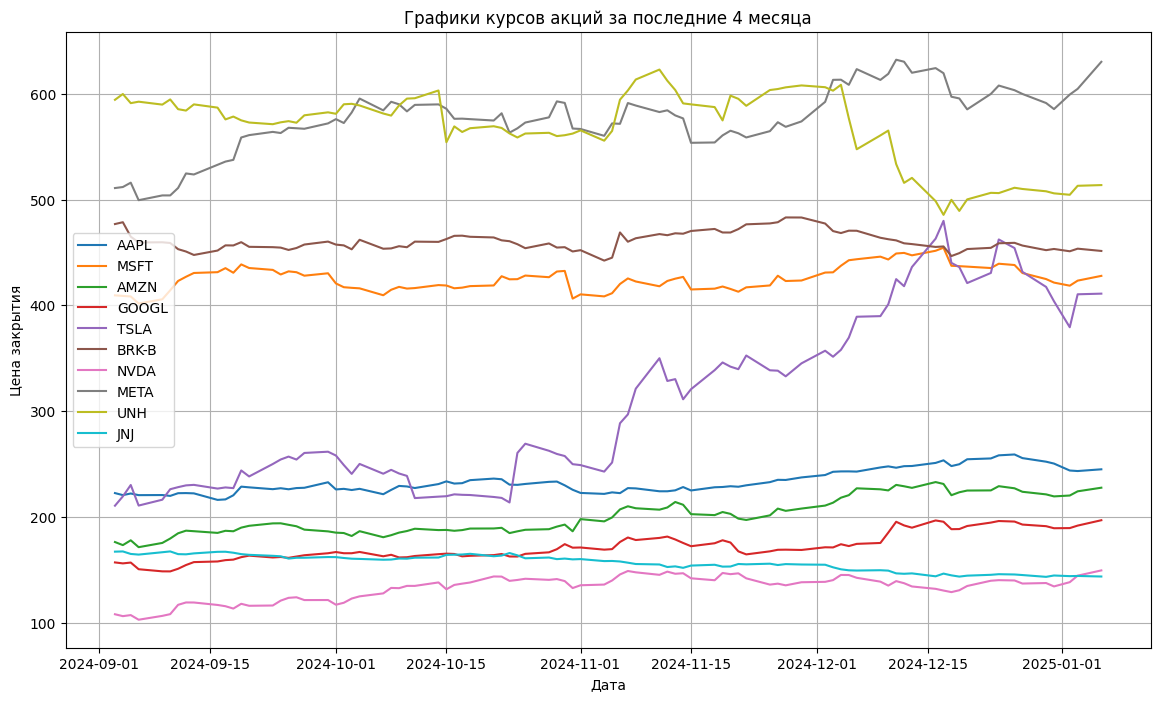

In [51]:
# Построение графиков
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=ticker)

plt.title('Графики курсов акций за последние 4 месяца')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid()
plt.show()

In [52]:
# Оптимизация для минимизации риска
optimal_risk = minimize(minimize_risk, initial_guess, args=(returns,),
                        method='SLSQP', bounds=bounds, constraints=constraints)

# Оптимизация для максимизации коэффициента Шарпа
optimal_sharpe = minimize(maximize_sharpe, initial_guess, args=(returns,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# Создание таблицы для минимизации риска
risk_table = pd.DataFrame({
    'Акция': tickers,
    'Доля': np.round(optimal_risk.x, 8)
})

# Создание таблицы для максимизации коэффициента Шарпа
sharpe_table = pd.DataFrame({
    'Акция': tickers,
    'Доля': np.round(optimal_sharpe.x, 8)
})

# Вывод таблиц с помощью tabulate
print("Оптимальные доли для минимизации риска:")
print(tabulate(risk_table, headers='keys', tablefmt='pretty', showindex=False))

print("\nОптимальные доли для максимизации коэффициента Шарпа:")
print(tabulate(sharpe_table, headers='keys', tablefmt='pretty', showindex=False))


Оптимальные доли для минимизации риска:
+-------+------------+
| Акция |    Доля    |
+-------+------------+
| AAPL  | 0.14928224 |
| MSFT  | 0.0020347  |
| AMZN  | 0.06143011 |
| GOOGL | 0.06873472 |
| TSLA  | 0.55010356 |
| BRK-B | 0.06360289 |
| NVDA  |    0.0     |
| META  | 0.05313827 |
|  UNH  |    0.0     |
|  JNJ  | 0.05167351 |
+-------+------------+

Оптимальные доли для максимизации коэффициента Шарпа:
+-------+------------+
| Акция |    Доля    |
+-------+------------+
| AAPL  | 0.08024383 |
| MSFT  | 0.12931592 |
| AMZN  |    0.0     |
| GOOGL | 0.1949956  |
| TSLA  |    0.0     |
| BRK-B | 0.12156558 |
| NVDA  |    0.0     |
| META  | 0.27186629 |
|  UNH  | 0.20201279 |
|  JNJ  |    0.0     |
+-------+------------+


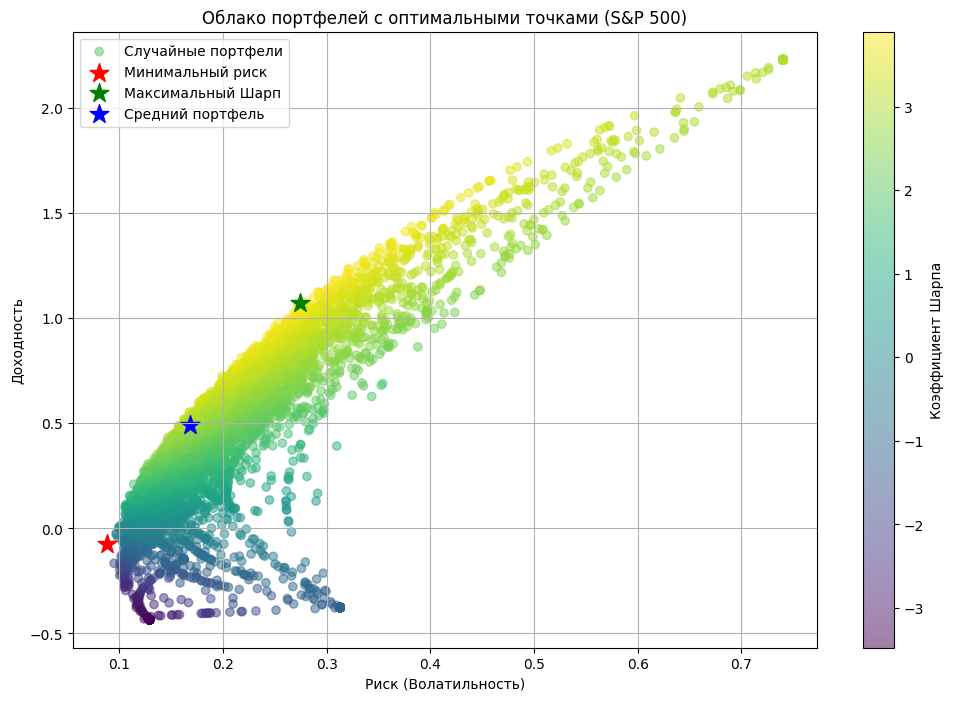

In [53]:
# Генерация случайных портфелей
num_portfolios = 10000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    # Случайное количество акций (N), в которые будут вложены средства
    N = np.random.randint(1, num_assets + 1)  # N от 1 до num_assets
    selected_assets = np.random.choice(num_assets, N, replace=False)  # Случайный выбор N акций
    
    # Генерация весов только для выбранных акций
    weights = np.zeros(num_assets)
    selected_weights = np.random.random(N)
    selected_weights /= np.sum(selected_weights)  # Нормализация весов
    weights[selected_assets] = selected_weights
    
    # Расчет доходности и риска портфеля
    ret, vol = portfolio_stats(weights, returns)
    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = (ret - 0) / vol  # Коэффициент Шарпа (без учета безрисковой ставки)

# Построение графика
plt.figure(figsize=(12, 8))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.5, label='Случайные портфели')
plt.colorbar(label='Коэффициент Шарпа')

# Добавление точек для оптимальных портфелей
min_risk_ret, min_risk_vol = portfolio_stats(optimal_risk.x, returns)
plt.scatter(min_risk_vol, min_risk_ret, color='red', marker='*', s=200, label='Минимальный риск')

max_sharpe_ret, max_sharpe_vol = portfolio_stats(optimal_sharpe.x, returns)
plt.scatter(max_sharpe_vol, max_sharpe_ret, color='green', marker='*', s=200, label='Максимальный Шарп')

equal_weights = np.array([1 / num_assets] * num_assets)
equal_ret, equal_vol = portfolio_stats(equal_weights, returns)
plt.scatter(equal_vol, equal_ret, color='blue', marker='*', s=200, label='Средний портфель')

# Настройка графика
plt.title('Облако портфелей с оптимальными точками (S&P 500)')
plt.xlabel('Риск (Волатильность)')
plt.ylabel('Доходность')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [54]:
# Средний портфель
equal_weights = np.array([1 / num_assets] * num_assets)
equal_ret, equal_vol = portfolio_stats(equal_weights, returns)

# Портфель с минимальным риском
min_risk_ret, min_risk_vol = portfolio_stats(optimal_risk.x, returns)

# Портфель с максимальным коэффициентом Шарпа
max_sharpe_ret, max_sharpe_vol = portfolio_stats(optimal_sharpe.x, returns)

# Создаем таблицу
table = [
    ["Средний портфель", equal_ret, equal_vol, equal_weights],
    ["Минимальный риск", min_risk_ret, min_risk_vol, (optimal_risk.x)],
    ["Максимальный коэффициент Шарпа", max_sharpe_ret, max_sharpe_vol, (optimal_sharpe.x)]
]

# Форматируем вывод
headers = ["Тип портфеля", "Доходность", "Риск", "Доли"]
print(tabulate(table, headers=headers, floatfmt=".4f"))

Тип портфеля                      Доходность    Риск  Доли
------------------------------  ------------  ------  ------------------------------------------------------------------
Средний портфель                      0.4889  0.1678  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Минимальный риск                     -0.0773  0.0876  [0.14928224 0.0020347  0.06143011 0.06873472 0.55010356 0.06360289
                                                       0.         0.05313827 0.         0.05167351]
Максимальный коэффициент Шарпа        1.0724  0.2747  [0.08024383 0.12931592 0.         0.1949956  0.         0.12156558
                                                       0.         0.27186629 0.20201279 0.        ]


Вывод 2:
в целом, ожидаемо, что доходность будет выше при меньших рисках в данных акциях. Минимальный риск себя не оправдывает, тут уже лучше вклад опять же.